In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from os.path import join
from fiona.crs import from_epsg
from shapely.geometry import Point

# Load Data

In [2]:
path_parks= r'M:\NY4P Metrics Research 18034\03_GIS+ANALYSIS\01_DATA\RAW\Parks Historical Permits'

In [3]:
iso= gpd.read_file(r"M:/NY4P Metrics Research 18034/03_GIS+ANALYSIS/01_DATA/Processed/Isochrones/major_park_isochrones_190516.shp")

In [4]:
parks= gpd.read_file(r'M:/NY4P Metrics Research 18034/03_GIS+ANALYSIS/01_DATA/Processed/Parks/major_parks.shp')

In [5]:
pop= pd.read_csv(r"M:\NY4P Metrics Research 18034\03_GIS+ANALYSIS\01_DATA\Census\190702_totpopACS2017bg.csv",dtype={'Id2':str})

In [6]:
blocks= gpd.read_file(r"S:\NYC_GIS_DATA\Census block groups 2010\tl_2010_36_bg10.shp")

In [7]:
perms= pd.read_csv(join(path_parks, '190618_ParksPermits_ADDCOLS.csv'), low_memory=False, index_col=0)

In [8]:
perms['start_date_time']= pd.to_datetime(perms['start_date_time'])
perms['end_date_time']= pd.to_datetime(perms['end_date_time'])

perms['year']= perms['start_date_time'].dt.year
perms['start_time']= perms['start_date_time'].dt.time
perms['end_time']= perms['end_date_time'].dt.time

perms['date']= perms['start_date_time'].dt.date
perms['dow']= perms['start_date_time'].dt.weekday

In [9]:
min5_mask= iso['walk_mins']==5
min10_mask= iso['walk_mins']==10
min15_mask= iso['walk_mins']==15

In [10]:
iso.head()

,GISPROPNUM,walk_mins,SIGNNAME,TYPECATEGO,WATERFRONT,ACRES,geometry
0,Q104,5,Queensbridge Park,Community Park,Yes,20.340,"POLYGON ((588759.0487540175 4511769.537098425,..."
1,B129,5,Kaiser Park,Community Park,Yes,26.257,"POLYGON ((585403.4620365126 4492244.384107316,..."
2,B126,5,Red Hook Recreation Area,Community Park,Yes,58.503,"POLYGON ((584262.132522112 4502487.680308868, ..."
3,Q371,5,Rockaway Community Park,Community Park,Yes,255.400,"POLYGON ((602870.5673349533 4494519.520182735,..."
4,M353,5,Riverside Park South,Community Park,Yes,66.693,"POLYGON ((584948.9258486426 4514054.052222983,..."


In [11]:
iso.shape

(246, 7)

In [12]:
iso[min5_mask].shape

(82, 7)

In [13]:
iso['GISPROPNUM'].unique().shape

(82,)

In [14]:
iso= iso.to_crs({'init':'epsg:2263'})

In [15]:
blocks= blocks.to_crs({'init':'epsg:2263'})

In [16]:
blocks['Shape_area']= blocks.area

In [17]:
blocks['GEOID10'].head()

0    360070121011
1    360070121014
2    360070121013
3    360070121024
4    360070121023
Name: GEOID10, dtype: object

In [18]:
pop['Id2'].head()

0    360050001000
1    360050001001
2    360050002000
3    360050002001
4    360050002002
Name: Id2, dtype: object

In [19]:
blocks['Id2']= blocks['GEOID10']

In [20]:
popblocks= pd.merge(blocks,pop,how='inner',on='Id2')

In [21]:
popblocks['PopDens']= popblocks['Estimate; Total']  * 5280/popblocks['Shape_area']

In [22]:
iso.crs

{'init': 'epsg:2263'}

In [23]:
popblocks.crs

{'init': 'epsg:2263'}

In [24]:
pop_walk= gpd.sjoin(iso,popblocks,how='right',op='intersects').groupby(['GISPROPNUM','walk_mins']).agg({'Estimate; Total':sum}).rename(columns={'Estimate; Total':'TotalPop'})

In [25]:
pop_walk= pop_walk.reset_index()

In [26]:
pop_walk= pd.merge(iso[['GISPROPNUM','walk_mins','geometry']],pop_walk,on=['GISPROPNUM','walk_mins'],how='left')

In [27]:
pop_walk['Shape_area']= pop_walk.area
pop_walk['PopDens']= pop_walk['TotalPop']/pop_walk['Shape_area'] * 5280
#Total population and population density (people per square mile)

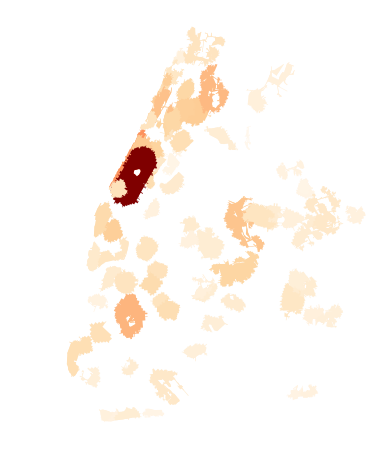

In [28]:
pop_walk.plot(column='TotalPop',cmap='OrRd',figsize=(8,8))
plt.axis('off');

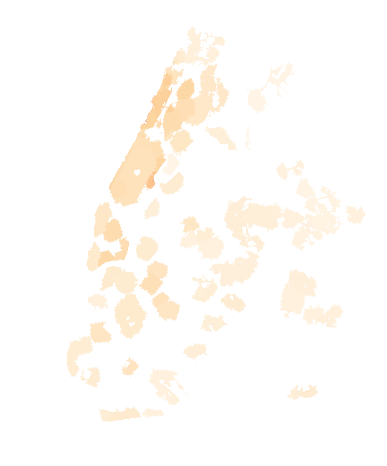

In [29]:
pop_walk.plot(column='PopDens',cmap='OrRd',figsize=(8,8))
plt.axis('off');

# Initial Options

In [30]:
path_exp= r"M:\NY4P Metrics Research 18034\05_GRAPHICS\Charts Graphs Diagrams\plt saves\190702 population initial options"

## Total Permits and Events by Park Type, Log Min-Max Normalized

In [31]:
mask_1318= perms['year'].isin(np.arange(2013,2019,1))

In [32]:
y2y= perms[perms['year'].isin(np.arange(2013,2019,1))].groupby(['GISPROPNUM','year']).agg({'GISPROPNUM':'count'}).unstack()

In [33]:
y2y.columns= [2013, 2014, 2015, 2016, 2017, 2018]

In [34]:
y2y.fillna(0, inplace=True)

In [35]:
y2y['tp']= y2y[[2013, 2014, 2015, 2016, 2017, 2018]].sum(axis=1)

### Log Min-Max Normalize

In [36]:
tmax= y2y['tp'].max()
tmin= y2y['tp'].min()

In [37]:
y2y['tp_mm']= (y2y['tp'].apply(lambda x: (x-tmin)/(tmax-tmin))*100).round(0)
y2y['tp_lmm']= (y2y['tp'].apply(lambda x: (np.log(x)-np.log(tmin))/(np.log(tmax)-np.log(tmin)))*100).round(0)

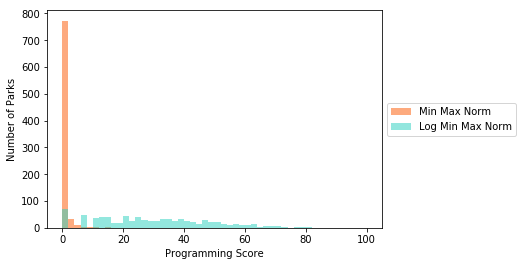

In [38]:
a= y2y['tp_mm'].values
b= y2y['tp_lmm'].values

bins= np.arange(0, 102, 2)

#plt.hist(aa, bins, alpha=0.5, label='All', color='#dfdfdf')
plt.hist(a, bins, alpha=0.5, label='Min Max Norm', color='#FD5700')
plt.hist(b, bins, alpha=0.5, label='Log Min Max Norm', color='#29D0BF')
#plt.hist(a, bins, alpha=0.5, label='Not Reported', color='#9355B0')

plt.legend(loc='center left', bbox_to_anchor=(1,.5))
plt.xlabel('Programming Score')
plt.ylabel('Number of Parks')

plt.savefig(join(path_exp, 'Total Events_MM_LMM.pdf'))

plt.show();

In [39]:
y2y.reset_index(inplace=True)
y2y

,GISPROPNUM,2013,2014,2015,2016,2017,2018,tp,tp_mm,tp_lmm
0,B001,2.0,2.0,3.0,4.0,3.0,6.0,20.0,0.0,28.0
1,B002,5.0,16.0,16.0,19.0,14.0,15.0,85.0,0.0,42.0
2,B006,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,B007,8.0,15.0,21.0,21.0,14.0,20.0,99.0,0.0,44.0
4,B008,17.0,37.0,18.0,25.0,29.0,27.0,153.0,0.0,48.0
5,B016,63.0,84.0,88.0,81.0,43.0,52.0,411.0,1.0,57.0
6,B018,105.0,138.0,153.0,199.0,281.0,312.0,1188.0,3.0,67.0
7,B019,81.0,54.0,75.0,111.0,112.0,108.0,541.0,1.0,60.0
8,B021,57.0,95.0,133.0,123.0,42.0,93.0,543.0,1.0,60.0
9,B022,1.0,6.0,5.0,5.0,0.0,4.0,21.0,0.0,29.0


### Evaluate by Park Type

In [40]:
uparks= perms[~perms[['GISPROPNUM', 'TYPECATEGO']].duplicated()][['GISPROPNUM', 'TYPECATEGO']].reset_index(drop=True)

In [41]:
y2y= pd.merge(uparks, y2y, on='GISPROPNUM', how='right')

In [42]:
park_types= y2y['TYPECATEGO'].unique()

In [43]:
fordf= []

for p in park_types:
    v= y2y[y2y['TYPECATEGO']==p]['tp'].values
    fordf.append([p, v.max(), v.min()])

In [44]:
minmaxes= pd.DataFrame(np.array(fordf), columns=['TYPECATEGO', 'MAX', 'MIN']).set_index('TYPECATEGO')

In [45]:
for n, s in minmaxes.iteritems():
    minmaxes[n]= s.astype(np.float32)

In [46]:
minmaxes['DELTA']= minmaxes['MAX']-minmaxes['MIN']

In [47]:
minmaxes

,MAX,MIN,DELTA
TYPECATEGO,,,
Neighborhood Park,5705.0,1.0,5704.0
Community Park,5412.0,1.0,5411.0
Flagship Park,38611.0,365.0,38246.0
Waterfront Facility,2588.0,1.0,2587.0
Recreation Field/Courts,1916.0,1.0,1915.0
Playground,434.0,1.0,433.0
Nature Area,862.0,1.0,861.0
Triangle/Plaza,1091.0,1.0,1090.0
Jointly Operated Playground,387.0,1.0,386.0


In [48]:
def park_type_adjusted(x, pt, lookup):
    try:
        mi= np.log(lookup.loc[pt, 'MIN'])
        mx= np.log(lookup.loc[pt, 'MAX'])
        dt= mx-mi
        return round((np.log(x)-mi)/dt*100, 0)
    except KeyError:
        return np.nan

In [49]:
y2y['tp_palmm']= [park_type_adjusted(x, pt, minmaxes) for x, pt in y2y[['tp', 'TYPECATEGO']].itertuples(index=False)]

In [50]:
y2y['tp_palmm'].max()

100.0

In [51]:
three_colors= ['#FD5700', '#29D0BF', '#9355B0']

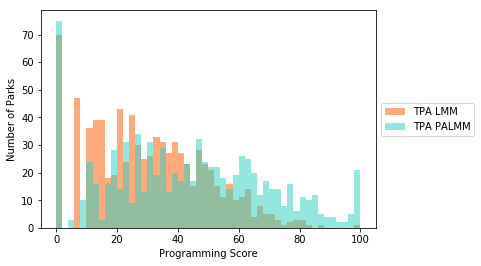

In [52]:
bins= np.arange(0, 102, 2)

tp_lmm= y2y['tp_lmm'].values
tp_palmm= y2y['tp_palmm'].values

plt.hist(tp_lmm, bins, alpha=0.5, label='TPA LMM', color=three_colors[0])
plt.hist(tp_palmm, bins, alpha=0.5, label='TPA PALMM', color=three_colors[1])

plt.legend(loc='center left', bbox_to_anchor=(1,.5))
plt.xlabel('Programming Score')
plt.ylabel('Number of Parks')

plt.savefig(join(path_exp, 'Total Events_Park Type or Not_LMM.pdf'))

plt.show();

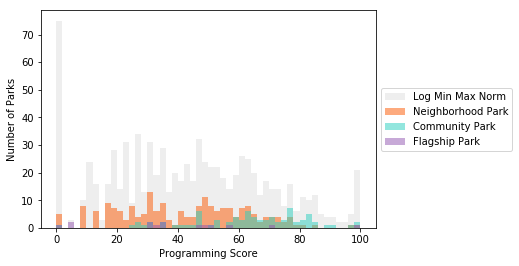

In [53]:
bins= np.arange(0, 102, 2)

plt.hist(y2y['tp_palmm'].values, bins, alpha=0.5, label='Log Min Max Norm', color='#dfdfdf')

for pt, c in zip(['Neighborhood Park', 'Community Park', 'Flagship Park'], three_colors):
    scores= y2y[y2y['TYPECATEGO']==pt]['tp_palmm'].values
    plt.hist(scores, bins, alpha=0.5, label=pt, color=c)

plt.legend(loc='center left', bbox_to_anchor=(1,.5))
plt.xlabel('Programming Score')
plt.ylabel('Number of Parks')

plt.savefig(join(path_exp, 'Total Events_Park Type 1_LMM.pdf'))

plt.show();

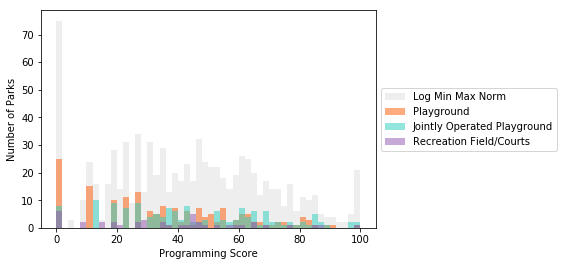

In [54]:
bins= np.arange(0, 102, 2)

plt.hist(y2y['tp_palmm'].values, bins, alpha=0.5, label='Log Min Max Norm', color='#dfdfdf')

for pt, c in zip(['Playground', 'Jointly Operated Playground', 'Recreation Field/Courts'], three_colors):
    scores= y2y[y2y['TYPECATEGO']==pt]['tp_palmm'].values
    plt.hist(scores, bins, alpha=0.5, label=pt, color=c)

plt.legend(loc='center left', bbox_to_anchor=(1,.5))
plt.xlabel('Programming Score')
plt.ylabel('Number of Parks')

#plt.savefig(join(path_exp, 'Total Events_Park Type 2_LMM.pdf'))

plt.show();

## Total Permits and Events per Person by Park Type, Log Min-Max Normalized

In [55]:
pop_walk2= pop_walk[pop_walk['walk_mins']==10]
#Setting only the walking distance = 10

In [56]:
pop_walk;

In [57]:
y2y= pd.merge(pop_walk2[['GISPROPNUM', 'TotalPop','PopDens']], y2y,  on='GISPROPNUM', how='right')

In [58]:
no0= y2y[y2y['TotalPop']!=0].copy().dropna(axis=0)

In [59]:
no0['tppop']= no0['tp']/no0['TotalPop']
no0['tppopdens']= no0['tp']/no0['PopDens']

In [60]:
no0['tppop'].min()

0.00032099048492491115

In [61]:
no0['tppopdens'].min()

0.6066218823275161

In [62]:
no0.shape

(64, 16)

In [63]:
no0;

### Log Min-Max Normalize

In [64]:
tmax= no0['tppop'].max()
tmin= no0['tppop'].min()
tmaxd= no0['tppopdens'].max()
tmind= no0['tppopdens'].min()

no0['tppop_mm']= no0['tppop'].apply(lambda x: (x-tmin)/(tmax-tmin))*100
no0['tppop_lmm']= no0['tppop'].apply(lambda x: (np.log(x)-np.log(tmin))/(np.log(tmax)-np.log(tmin)))*100

no0['tppopdens_mm']= no0['tppopdens'].apply(lambda x: (x-tmind)/(tmaxd-tmind))*100
no0['tppopdens_lmm']= no0['tppopdens'].apply(lambda x: (np.log(x)-np.log(tmind))/(np.log(tmaxd)-np.log(tmind)))*100

In [65]:
no0

,GISPROPNUM,TotalPop,PopDens,TYPECATEGO,2013,2014,2015,2016,2017,2018,tp,tp_mm,tp_lmm,tp_palmm,tppop,tppopdens,tppop_mm,tppop_lmm,tppopdens_mm,tppopdens_lmm
0,Q104,23683.0,13.799119,Community Park,63.0,76.0,61.0,51.0,65.0,88.0,404.0,1.0,57.0,70.0,0.017059,29.277231,0.370653,41.594549,0.921125,45.376893
1,B129,27764.0,15.200856,Community Park,69.0,142.0,162.0,151.0,172.0,110.0,806.0,2.0,63.0,78.0,0.029030,53.023329,0.635766,47.160932,1.684037,52.328839
2,B126,15116.0,7.543149,Community Park,52.0,109.0,92.0,31.0,24.0,49.0,357.0,1.0,56.0,68.0,0.023617,47.327712,0.515895,45.000471,1.501049,50.998713
3,Q371,14764.0,12.901824,Community Park,1.0,0.0,3.0,2.0,2.0,1.0,9.0,0.0,21.0,26.0,0.000610,0.697576,0.006391,6.714765,0.002922,1.635274
4,M353,37644.0,38.434391,Community Park,89.0,106.0,102.0,114.0,103.0,128.0,642.0,2.0,61.0,75.0,0.017055,16.703790,0.370561,41.592009,0.517168,38.808260
5,Q004,41211.0,12.522053,Community Park,208.0,270.0,219.0,266.0,165.0,241.0,1369.0,4.0,68.0,84.0,0.033219,109.327124,0.728528,48.572059,3.492958,60.798834
6,B021,33126.0,16.987275,Community Park,57.0,95.0,133.0,123.0,42.0,93.0,543.0,1.0,60.0,73.0,0.016392,31.965103,0.355889,41.177174,1.007481,46.405011
7,M089,90422.0,31.043122,Community Park,812.0,591.0,555.0,531.0,870.0,475.0,3834.0,10.0,78.0,96.0,0.042401,123.505619,0.931860,51.127047,3.948482,62.226185
8,M058,90784.0,27.162596,Community Park,124.0,165.0,270.0,212.0,225.0,253.0,1249.0,3.0,68.0,83.0,0.013758,45.982350,0.297559,39.343210,1.457825,50.661155
9,Q492,30581.0,16.483380,Community Park,20.0,26.0,32.0,40.0,22.0,27.0,167.0,0.0,48.0,60.0,0.005461,10.131417,0.113823,29.669569,0.306011,32.955749


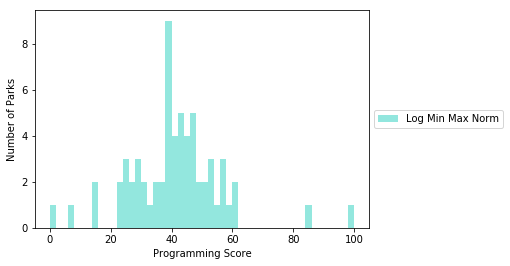

In [66]:
a= no0['tppop_mm'].values
b= no0['tppop_lmm'].values

bins= np.arange(0, 102, 2)

#plt.hist(a, bins, alpha=0.5, label='Min Max Norm', color='#FD5700')
plt.hist(b, bins, alpha=0.5, label='Log Min Max Norm', color='#29D0BF')

plt.legend(loc='center left', bbox_to_anchor=(1,.5))
plt.xlabel('Programming Score')
plt.ylabel('Number of Parks')

#plt.ylim((0,80))

plt.savefig(join(path_exp, 'Total Events by Population_LMM.pdf'))

plt.show();

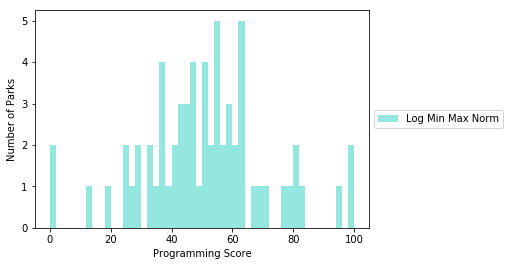

In [67]:
a= no0['tppopdens_mm'].values
b= no0['tppopdens_lmm'].values

bins= np.arange(0, 102, 2)

#plt.hist(a, bins, alpha=0.5, label='Min Max Norm', color='#FD5700')
plt.hist(b, bins, alpha=0.5, label='Log Min Max Norm', color='#29D0BF')

plt.legend(loc='center left', bbox_to_anchor=(1,.5))
plt.xlabel('Programming Score')
plt.ylabel('Number of Parks')

#plt.ylim((0,80))

plt.savefig(join(path_exp, 'Total Events by Population Density_LMM.pdf'))

plt.show();

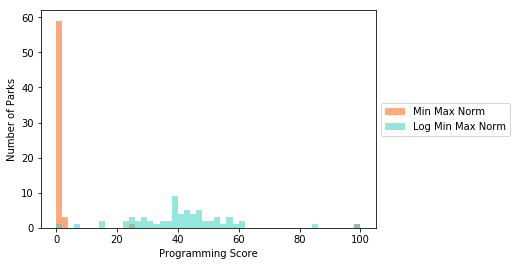

In [68]:
a= no0['tppop_mm'].values
b= no0['tppop_lmm'].values

bins= np.arange(0, 102, 2)

plt.hist(a, bins, alpha=0.5, label='Min Max Norm', color='#FD5700')
plt.hist(b, bins, alpha=0.5, label='Log Min Max Norm', color='#29D0BF')

plt.legend(loc='center left', bbox_to_anchor=(1,.5))
plt.xlabel('Programming Score')
plt.ylabel('Number of Parks')

#plt.ylim((0,80))

plt.savefig(join(path_exp, 'Total Events by Population_MM_LMM.pdf'))

plt.show();

In [69]:
iso[iso['walk_mins']==10].shape

(82, 7)

### Evaluate by Park Type

In [70]:
fordf2= []

for p in park_types:
    v= no0[no0['TYPECATEGO']==p]['tppop'].values
    if len(v)>0:
        fordf2.append([p, v.max(), v.min()])

minmaxes2= pd.DataFrame(np.array(fordf2), columns=['TYPECATEGO', 'MAX', 'MIN']).set_index('TYPECATEGO')

In [71]:
minmaxes2

,MAX,MIN
TYPECATEGO,,
Community Park,0.0921266819146525,0.00032099048492491115
Flagship Park,4.516042780748663,0.0034369560906827644


In [72]:
fordf2= []

for p in park_types:
    v= no0[no0['TYPECATEGO']==p]['tppopdens'].values
    if len(v)>0:
        fordf2.append([p, v.max(), v.min()])

minmaxes3= pd.DataFrame(np.array(fordf2), columns=['TYPECATEGO', 'MAX', 'MIN']).set_index('TYPECATEGO')

In [73]:
no0.loc[no0['tppop'].sort_values(ascending=False).head(10).index]

,GISPROPNUM,TotalPop,PopDens,TYPECATEGO,2013,2014,2015,2016,2017,2018,tp,tp_mm,tp_lmm,tp_palmm,tppop,tppopdens,tppop_mm,tppop_lmm,tppopdens_mm,tppopdens_lmm
45,X126,374.0,0.639061,Flagship Park,349.0,438.0,241.0,204.0,212.0,245.0,1689.0,4.0,70.0,33.0,4.516043,2642.939550,100.000000,100.000000,84.892513,98.083286
44,M104,2857.0,1.059049,Flagship Park,296.0,449.0,305.0,657.0,562.0,1028.0,3297.0,9.0,77.0,47.0,1.154008,3113.169602,25.548224,85.715734,100.000000,100.000000
23,Q021,31455.0,6.177977,Flagship Park,530.0,573.0,607.0,615.0,614.0,466.0,3405.0,9.0,77.0,48.0,0.108250,551.151260,2.390070,60.939567,17.687823,79.733847
55,M010,387964.0,19.767936,Flagship Park,5197.0,5884.0,7050.0,7010.0,6065.0,7405.0,38611.0,100.0,100.0,100.0,0.099522,1953.213525,2.196795,60.059493,62.733089,94.543463
52,B057,48531.0,7.528480,Community Park,193.0,765.0,783.0,939.0,944.0,847.0,4471.0,12.0,80.0,98.0,0.092127,593.878168,2.033024,59.251102,19.060548,80.607811
32,B251,7337.0,5.449925,Community Park,25.0,94.0,97.0,98.0,107.0,104.0,525.0,1.0,59.0,73.0,0.071555,96.331609,1.577470,56.605548,3.075439,59.317570
43,Q012,8569.0,4.535220,Community Park,108.0,120.0,152.0,64.0,49.0,114.0,607.0,2.0,61.0,75.0,0.070837,133.841357,1.561561,56.499907,4.280547,63.166912
63,B073,148041.0,14.815366,Flagship Park,1758.0,1731.0,1962.0,1738.0,1394.0,1564.0,10147.0,26.0,87.0,71.0,0.068542,684.897041,1.510740,56.155115,21.984789,82.276899
49,X092,56272.0,8.757345,Flagship Park,136.0,535.0,684.0,689.0,693.0,943.0,3680.0,10.0,78.0,50.0,0.065397,420.218671,1.441091,55.663339,13.481239,76.559011
57,Q099,98815.0,8.678365,Flagship Park,637.0,719.0,796.0,775.0,959.0,1354.0,5240.0,14.0,81.0,57.0,0.053028,603.800383,1.167198,53.468517,19.379327,80.801759


In [74]:
for n, s in minmaxes2.iteritems():
    minmaxes2[n]= s.astype(np.float32)

In [75]:
for n, s in minmaxes3.iteritems():
    minmaxes3[n]= s.astype(np.float32)

In [76]:
no0['tpc_ppoplmm']= [park_type_adjusted(x, pt, minmaxes2) for x, pt in no0[['tppop', 'TYPECATEGO']].itertuples(index=False)]

In [77]:
no0['tpc_ppopdenslmm']= [park_type_adjusted(x, pt, minmaxes3) for x, pt in no0[['tppopdens', 'TYPECATEGO']].itertuples(index=False)]

In [78]:
no0['tpc_ppoplmm']= no0['tpc_ppoplmm'].abs()

In [79]:
no0['tpc_ppopdenslmm']= no0['tpc_ppopdenslmm'].abs()

In [80]:
tpc_ppoplmm= no0['tpc_ppoplmm'].values

In [81]:
tpc_ppopdenslmm= no0['tpc_ppopdenslmm'].values

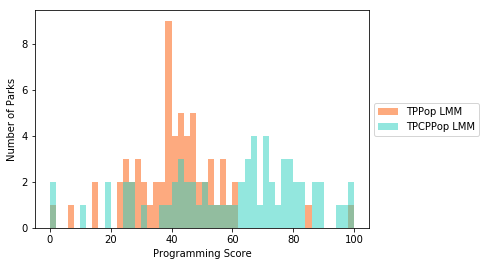

In [82]:
bins= np.arange(0, 102, 2)

tpa_lmm= no0['tppop_lmm'].values
tpa_palmm= no0['tpc_ppoplmm'].values

plt.hist(tpa_lmm, bins, alpha=0.5, label='TPPop LMM', color=three_colors[0])
plt.hist(tpa_palmm, bins, alpha=0.5, label='TPCPPop LMM', color=three_colors[1])

plt.legend(loc='center left', bbox_to_anchor=(1,.5))
plt.xlabel('Programming Score')
plt.ylabel('Number of Parks')

#plt.ylim((0,80))

plt.savefig(join(path_exp, 'Total Events by Population and Park Type or Not_LMM.pdf'))

plt.show();

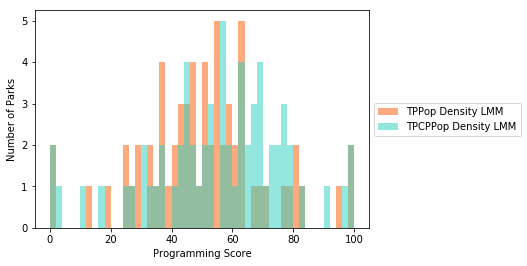

In [83]:
bins= np.arange(0, 102, 2)

tpa_lmm= no0['tppopdens_lmm'].values
tpa_palmm= no0['tpc_ppopdenslmm'].values

plt.hist(tpa_lmm, bins, alpha=0.5, label='TPPop Density LMM', color=three_colors[0])
plt.hist(tpa_palmm, bins, alpha=0.5, label='TPCPPop Density LMM', color=three_colors[1])

plt.legend(loc='center left', bbox_to_anchor=(1,.5))
plt.xlabel('Programming Score')
plt.ylabel('Number of Parks')

#plt.ylim((0,80))

plt.savefig(join(path_exp, 'Total Events by Population Density and Park Type or Not_LMM.pdf'))

plt.show();

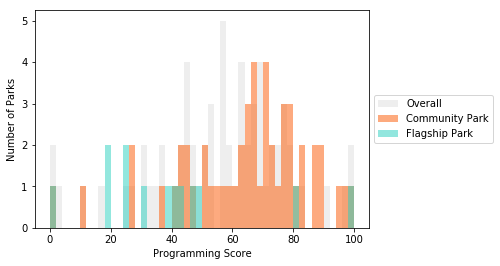

In [84]:
bins= np.arange(0, 102, 2)

plt.hist(tpa_palmm, bins, alpha=0.5, label='Overall', color='#dfdfdf')

for pt, c in zip(['Community Park', 'Flagship Park'], three_colors):
    scores= no0[no0['TYPECATEGO']==pt]['tpc_ppoplmm'].values
    plt.hist(scores, bins, alpha=0.5, label=pt, color=c)

plt.legend(loc='center left', bbox_to_anchor=(1,.5))
plt.xlabel('Programming Score')
plt.ylabel('Number of Parks')

plt.savefig(join(path_exp, 'Total Events by Population_Park Type 1_LMM.pdf'))

plt.show();

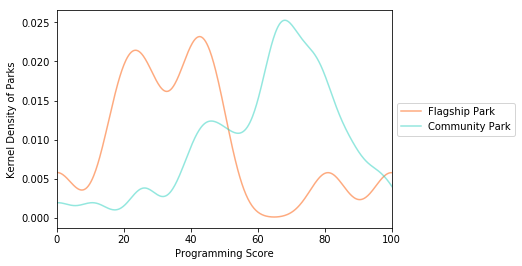

In [85]:
fig, ax= plt.subplots()

for pt, c in zip([ 'Flagship Park', 'Community Park'], three_colors):
    no0[no0['TYPECATEGO']==pt]['tpc_ppoplmm'].reset_index(drop=True)\
        .plot.kde(ax=ax, alpha=0.5, label=pt, color=c, bw_method=0.2)

plt.legend(loc='center left', bbox_to_anchor=(1,.5))
plt.xlabel('Programming Score')
plt.ylabel('Kernel Density of Parks')
plt.xlim((0,100))

plt.savefig(join(path_exp, 'Total Events by Population_Park Type 1_LMM_KDE.pdf'))

plt.show();

In [86]:
no0.head(2)

,GISPROPNUM,TotalPop,PopDens,TYPECATEGO,2013,2014,2015,2016,2017,2018,...,tp_lmm,tp_palmm,tppop,tppopdens,tppop_mm,tppop_lmm,tppopdens_mm,tppopdens_lmm,tpc_ppoplmm,tpc_ppopdenslmm
0,Q104,23683.0,13.799119,Community Park,63.0,76.0,61.0,51.0,65.0,88.0,...,57.0,70.0,0.017059,29.277231,0.370653,41.594549,0.921125,45.376893,70.0,56.0
1,B129,27764.0,15.200856,Community Park,69.0,142.0,162.0,151.0,172.0,110.0,...,63.0,78.0,0.029030,53.023329,0.635766,47.160932,1.684037,52.328839,80.0,65.0


# ABCDF Scoring

In [87]:
scoring= \
pd.read_html(r'https://www.mooxye.com/blog/en/american-grading-system-and-gpa/', skiprows=1)[0]\
    .rename(columns={0:'Grade Range', 1:'Grade', 2:'GPA'})

In [88]:
scoring['Lower']= pd.to_numeric(scoring['Grade Range'].str.split('-| ').apply(lambda x: x[0]), errors='coerce')
scoring['Upper']= pd.to_numeric(scoring['Grade Range'].str.split('-| ').apply(lambda x: x[1]), errors='coerce')

In [89]:
scoring.at[11,'Lower']= 0

In [90]:
scoring= scoring[::-1].reset_index(drop=True)

In [91]:
no0['tp_grade']= \
pd.cut(no0['tp_palmm'],
       bins=np.insert(scoring['Upper'].values, 0, -1),
       include_lowest=False, labels=scoring['Grade'].values)
no0['tp_grade']= no0['tp_grade'].astype(str)

no0['tppop_grade']= \
pd.cut(no0['tpc_ppoplmm'],
       bins=np.insert(scoring['Upper'].values, 0, -1),
       include_lowest=False, labels=scoring['Grade'].values)
no0['tppop_grade']= no0['tppop_grade'].astype(str)

no0['tppopdens_grade']= \
pd.cut(no0['tpc_ppopdenslmm'],
       bins=np.insert(scoring['Upper'].values, 0, -1),
       include_lowest=False, labels=scoring['Grade'].values)
no0['tppopdens_grade']= no0['tppopdens_grade'].astype(str)

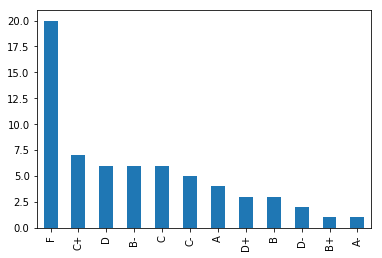

In [92]:
no0['tp_grade'].value_counts().plot.bar();

In [93]:
(no0['tp_grade'].value_counts()/825*100).round(0)

F     2.0
C+    1.0
D     1.0
B-    1.0
C     1.0
C-    1.0
A     0.0
D+    0.0
B     0.0
D-    0.0
B+    0.0
A-    0.0
Name: tp_grade, dtype: float64

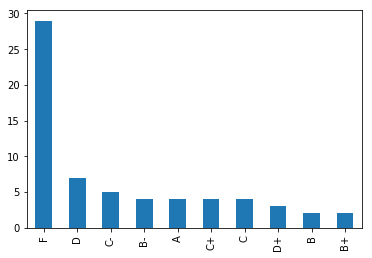

In [94]:
no0['tppop_grade'].value_counts().plot.bar();

In [95]:
(no0['tppop_grade'].value_counts()/825*100).round(0)

F     4.0
D     1.0
C-    1.0
B-    0.0
A     0.0
C+    0.0
C     0.0
D+    0.0
B     0.0
B+    0.0
Name: tppop_grade, dtype: float64

In [96]:
fff= pd.merge(parks[['GISPROPNUM', 'SIGNNAME']], no0, on='GISPROPNUM', how='right')

In [97]:
fff

,GISPROPNUM,SIGNNAME,TotalPop,PopDens,TYPECATEGO,2013,2014,2015,2016,2017,...,tppopdens,tppop_mm,tppop_lmm,tppopdens_mm,tppopdens_lmm,tpc_ppoplmm,tpc_ppopdenslmm,tp_grade,tppop_grade,tppopdens_grade
0,Q104,Queensbridge Park,23683.0,13.799119,Community Park,63.0,76.0,61.0,51.0,65.0,...,29.277231,0.370653,41.594549,0.921125,45.376893,70.0,56.0,C-,C-,F
1,B129,Kaiser Park,27764.0,15.200856,Community Park,69.0,142.0,162.0,151.0,172.0,...,53.023329,0.635766,47.160932,1.684037,52.328839,80.0,65.0,C+,B-,D
2,B126,Red Hook Recreation Area,15116.0,7.543149,Community Park,52.0,109.0,92.0,31.0,24.0,...,47.327712,0.515895,45.000471,1.501049,50.998713,76.0,63.0,D+,C,D
3,Q371,Rockaway Community Park,14764.0,12.901824,Community Park,1.0,0.0,3.0,2.0,2.0,...,0.697576,0.006391,6.714765,0.002922,1.635274,11.0,2.0,F,F,F
4,M353,Riverside Park South,37644.0,38.434391,Community Park,89.0,106.0,102.0,114.0,103.0,...,16.703790,0.370561,41.592009,0.517168,38.808260,70.0,48.0,C,C-,F
5,Q004,Astoria Park,41211.0,12.522053,Community Park,208.0,270.0,219.0,266.0,165.0,...,109.327124,0.728528,48.572059,3.492958,60.798834,82.0,75.0,B,B-,C
6,B021,Commodore Barry Park,33126.0,16.987275,Community Park,57.0,95.0,133.0,123.0,42.0,...,31.965103,0.355889,41.177174,1.007481,46.405011,69.0,58.0,C,D+,F
7,M089,Union Square Park,90422.0,31.043122,Community Park,812.0,591.0,555.0,531.0,870.0,...,123.505619,0.931860,51.127047,3.948482,62.226185,86.0,77.0,A,B,C+
8,M058,Marcus Garvey Park,90784.0,27.162596,Community Park,124.0,165.0,270.0,212.0,225.0,...,45.982350,0.297559,39.343210,1.457825,50.661155,66.0,63.0,B,D,D
9,Q492,Elmhurst Park,30581.0,16.483380,Community Park,20.0,26.0,32.0,40.0,22.0,...,10.131417,0.113823,29.669569,0.306011,32.955749,50.0,41.0,F,F,F


In [98]:
fff.sort_values('tppop').tail(10)

,GISPROPNUM,SIGNNAME,TotalPop,PopDens,TYPECATEGO,2013,2014,2015,2016,2017,...,tppopdens,tppop_mm,tppop_lmm,tppopdens_mm,tppopdens_lmm,tpc_ppoplmm,tpc_ppopdenslmm,tp_grade,tppop_grade,tppopdens_grade
57,Q099,Flushing Meadows Corona Park,98815.0,8.678365,Flagship Park,637.0,719.0,796.0,775.0,959.0,...,603.800383,1.167198,53.468517,19.379327,80.801759,38.0,65.0,F,F,D
49,X092,Van Cortlandt Park,56272.0,8.757345,Flagship Park,136.0,535.0,684.0,689.0,693.0,...,420.218671,1.441091,55.663339,13.481239,76.559011,41.0,57.0,F,F,F
63,B073,Prospect Park,148041.0,14.815366,Flagship Park,1758.0,1731.0,1962.0,1738.0,1394.0,...,684.897041,1.510740,56.155115,21.984789,82.276899,42.0,68.0,C-,F,D+
43,Q012,Crocheron Park,8569.0,4.535220,Community Park,108.0,120.0,152.0,64.0,49.0,...,133.841357,1.561561,56.499907,4.280547,63.166912,95.0,78.0,C,A,C+
32,B251,Manhattan Beach Park,7337.0,5.449925,Community Park,25.0,94.0,97.0,98.0,107.0,...,96.331609,1.577470,56.605548,3.075439,59.317570,96.0,74.0,C,A,C
52,B057,Marine Park,48531.0,7.528480,Community Park,193.0,765.0,783.0,939.0,944.0,...,593.878168,2.033024,59.251102,19.060548,80.607811,100.0,100.0,A,A,A
55,M010,Central Park,387964.0,19.767936,Flagship Park,5197.0,5884.0,7050.0,7010.0,6065.0,...,1953.213525,2.196795,60.059493,62.733089,94.543463,47.0,90.0,A,F,A-
23,Q021,Cunningham Park,31455.0,6.177977,Flagship Park,530.0,573.0,607.0,615.0,614.0,...,551.151260,2.390070,60.939567,17.687823,79.733847,48.0,63.0,F,F,D
44,M104,Randall's Island Park,2857.0,1.059049,Flagship Park,296.0,449.0,305.0,657.0,562.0,...,3113.169602,25.548224,85.715734,100.000000,100.000000,81.0,100.0,F,B-,A
45,X126,Ferry Point Park,374.0,0.639061,Flagship Park,349.0,438.0,241.0,204.0,212.0,...,2642.939550,100.000000,100.000000,84.892513,98.083286,100.0,97.0,F,A,A


In [99]:
no0.sort_values('tp').tail(10)

,GISPROPNUM,TotalPop,PopDens,TYPECATEGO,2013,2014,2015,2016,2017,2018,...,tppopdens,tppop_mm,tppop_lmm,tppopdens_mm,tppopdens_lmm,tpc_ppoplmm,tpc_ppopdenslmm,tp_grade,tppop_grade,tppopdens_grade
47,M042,46171.0,16.470917,Community Park,151.0,224.0,189.0,439.0,615.0,672.0,...,139.032943,1.091237,52.768412,4.447342,63.612359,89.0,79.0,A-,B+,C+
44,M104,2857.0,1.059049,Flagship Park,296.0,449.0,305.0,657.0,562.0,1028.0,...,3113.169602,25.548224,85.715734,100.000000,100.000000,81.0,100.0,F,B-,A
23,Q021,31455.0,6.177977,Flagship Park,530.0,573.0,607.0,615.0,614.0,466.0,...,551.151260,2.390070,60.939567,17.687823,79.733847,48.0,63.0,F,F,D
49,X092,56272.0,8.757345,Flagship Park,136.0,535.0,684.0,689.0,693.0,943.0,...,420.218671,1.441091,55.663339,13.481239,76.559011,41.0,57.0,F,F,F
7,M089,90422.0,31.043122,Community Park,812.0,591.0,555.0,531.0,870.0,475.0,...,123.505619,0.931860,51.127047,3.948482,62.226185,86.0,77.0,A,B,C+
52,B057,48531.0,7.528480,Community Park,193.0,765.0,783.0,939.0,944.0,847.0,...,593.878168,2.033024,59.251102,19.060548,80.607811,100.0,100.0,A,A,A
57,Q099,98815.0,8.678365,Flagship Park,637.0,719.0,796.0,775.0,959.0,1354.0,...,603.800383,1.167198,53.468517,19.379327,80.801759,38.0,65.0,F,F,D
36,M071,201390.0,28.693180,Community Park,745.0,759.0,888.0,863.0,1154.0,1003.0,...,188.616249,0.587995,46.352567,6.040348,67.182473,78.0,83.0,A,C+,B
63,B073,148041.0,14.815366,Flagship Park,1758.0,1731.0,1962.0,1738.0,1394.0,1564.0,...,684.897041,1.510740,56.155115,21.984789,82.276899,42.0,68.0,C-,F,D+
55,M010,387964.0,19.767936,Flagship Park,5197.0,5884.0,7050.0,7010.0,6065.0,7405.0,...,1953.213525,2.196795,60.059493,62.733089,94.543463,47.0,90.0,A,F,A-


## Exports for Comparison

In [142]:
comp= pd.read_csv(r"M:\NY4P Metrics Research 18034\03_GIS+ANALYSIS\01_DATA\Processed\Initial Options\190618_TParks by Acre.csv",index_col=0)

In [143]:
comp= pd.merge(comp,no0,on='GISPROPNUM',how='inner')

In [163]:
comp.loc[:,'tpa_palmm':].head()

,tpa_palmm,tp_grade_x,tpa_grade,TotalPop,PopDens,TYPECATEGO_y,2013,2014,2015,2016,...,tppopdens,tppop_mm,tppop_lmm,tppopdens_mm,tppopdens_lmm,tpc_ppoplmm,tpc_ppopdenslmm,tp_grade_y,tppop_grade,tppopdens_grade
0,65.0,C-,D,23683.0,13.799119,Community Park,63.0,76.0,61.0,51.0,...,29.277231,0.370653,41.594549,0.921125,45.376893,70.0,56.0,C-,C-,F
1,70.0,C+,C-,27764.0,15.200856,Community Park,69.0,142.0,162.0,151.0,...,53.023329,0.635766,47.160932,1.684037,52.328839,80.0,65.0,C+,B-,D
2,53.0,D+,F,15116.0,7.543149,Community Park,52.0,109.0,92.0,31.0,...,47.327712,0.515895,45.000471,1.501049,50.998713,76.0,63.0,D+,C,D
3,0.0,F,F,14764.0,12.901824,Community Park,1.0,0.0,3.0,2.0,...,0.697576,0.006391,6.714765,0.002922,1.635274,11.0,2.0,F,F,F
4,58.0,C,F,37644.0,38.434391,Community Park,89.0,106.0,102.0,114.0,...,16.703790,0.370561,41.592009,0.517168,38.808260,70.0,48.0,C,C-,F


In [164]:
comp.columns

Index([     'GISPROPNUM',           'ACRES',    'TYPECATEGO_x',
                  '2013',            '2014',            '2015',
                  '2016',            '2017',            '2018',
                  'tp_x',         'tp_mm_x',        'tp_lmm_x',
            'tp_palmm_x',             'tpa',          'tpa_mm',
               'tpa_lmm',       'tpa_palmm',      'tp_grade_x',
             'tpa_grade',        'TotalPop',         'PopDens',
          'TYPECATEGO_y',              2013,              2014,
                    2015,              2016,              2017,
                    2018,            'tp_y',         'tp_mm_y',
              'tp_lmm_y',      'tp_palmm_y',           'tppop',
             'tppopdens',        'tppop_mm',       'tppop_lmm',
          'tppopdens_mm',   'tppopdens_lmm',     'tpc_ppoplmm',
       'tpc_ppopdenslmm',      'tp_grade_y',     'tppop_grade',
       'tppopdens_grade'],
      dtype='object')

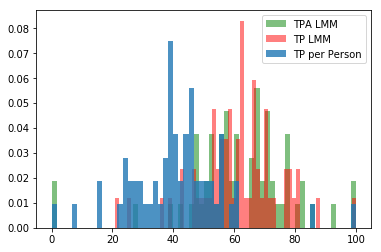

In [180]:
plt.hist(comp['tpa_palmm'],bins=60,density=True,color='green',alpha=0.5,label='TPA LMM')
plt.hist(comp['tp_lmm_x'],bins=60,density=True,color='red',alpha=0.5,label='TP LMM')
plt.hist(comp['tppop_lmm'],bins=60,density=True,alpha=0.8,label='TP per Person')
plt.legend();

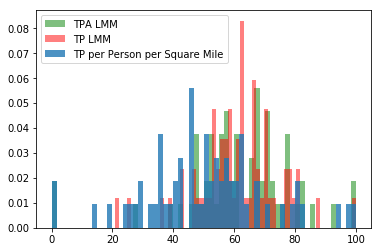

In [179]:
plt.hist(comp['tpa_palmm'],bins=60,density=True,color='green',alpha=0.5,label='TPA LMM')
plt.hist(comp['tp_lmm_x'],bins=60,density=True,color='red',alpha=0.5,label='TP LMM')
plt.hist(comp['tppopdens_lmm'],bins=60,density=True,alpha=0.8,label='TP per Person per Square Mile')
plt.legend();

In [ ]:
plt.hist(comp['tppop_lmm'],bins=60,density=True)
plt.hist(comp['tpa_palmm'],bins=60,density=True,color='green');

In [104]:
ABchange= sum(comp['tpa_grade'].str.contains('A')&comp['tppop_grade'].str.contains('B'))
BAchange= sum(comp['tpa_grade'].str.contains('B')&comp['tppop_grade'].str.contains('A'))

ACchange= sum(comp['tpa_grade'].str.contains('A')&comp['tppop_grade'].str.contains('C'))
CAchange= sum(comp['tpa_grade'].str.contains('C')&comp['tppop_grade'].str.contains('A'))

BCchange= sum(comp['tpa_grade'].str.contains('B')&comp['tppop_grade'].str.contains('C'))
CBchange= sum(comp['tpa_grade'].str.contains('C')&comp['tppop_grade'].str.contains('B'))

BDchange= sum(comp['tpa_grade'].str.contains('B')&comp['tppop_grade'].str.contains('D'))
DBchange= sum(comp['tpa_grade'].str.contains('D')&comp['tppop_grade'].str.contains('B'))

CDchange= sum(comp['tpa_grade'].str.contains('C')&comp['tppop_grade'].str.contains('D'))
DCchange= sum(comp['tpa_grade'].str.contains('D')&comp['tppop_grade'].str.contains('C'))

ADchange= sum(comp['tpa_grade'].str.contains('A')&comp['tppop_grade'].str.contains('D'))
DAchange= sum(comp['tpa_grade'].str.contains('D')&comp['tppop_grade'].str.contains('A'))

AFchange= sum(comp['tpa_grade'].str.contains('A')&comp['tppop_grade'].str.contains('F'))
FAchange= sum(comp['tpa_grade'].str.contains('F')&comp['tppop_grade'].str.contains('A'))

DFchange= sum(comp['tpa_grade'].str.contains('D')&comp['tppop_grade'].str.contains('F'))
FDchange= sum(comp['tpa_grade'].str.contains('F')&comp['tppop_grade'].str.contains('D'))

BFchange= sum(comp['tpa_grade'].str.contains('B')&comp['tppop_grade'].str.contains('F'))
FBchange= sum(comp['tpa_grade'].str.contains('F')&comp['tppop_grade'].str.contains('B'))


BFchange= sum(comp['tpa_grade'].str.contains('B')&comp['tppop_grade'].str.contains('F'))
FBchange= sum(comp['tpa_grade'].str.contains('F')&comp['tppop_grade'].str.contains('B'))

In [109]:
64-sum(comp[['tppop_grade','tpa_grade']]['tppop_grade']==comp[['tppop_grade','tpa_grade']]['tpa_grade'])

44

In [123]:
y= comp[['tp_grade_x','tppop_grade']].groupby(['tp_grade_x','tppop_grade']).agg({'tppop_grade':'count'})['tppop_grade'].unstack().fillna(0)

In [124]:
y

tppop_grade,A,B,B+,B-,C,C+,C-,D,D+,F
tp_grade_x,,,,,,,,,,
A,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
A-,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0
B+,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
B-,0.0,0.0,1.0,0.0,1.0,2.0,2.0,0.0,0.0,0.0
C,2.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0
C+,0.0,1.0,0.0,2.0,0.0,0.0,0.0,3.0,0.0,1.0
C-,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,2.0
D,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,4.0


In [122]:
t

tppopdens_grade,A,A-,B,C,C+,C-,D,D+,D-,F
tp_grade_x,,,,,,,,,,
A,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
A-,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
B,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0
B+,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
B-,0.0,0.0,0.0,1.0,1.0,1.0,0.0,2.0,0.0,1.0
C,0.0,0.0,0.0,1.0,1.0,2.0,0.0,0.0,0.0,2.0
C+,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,3.0
C-,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,3.0
D,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0


In [115]:
t.to_csv(join(path_exp,'190702_TpA_Grade and TPPop_Grade_Export Score Change.csv'))

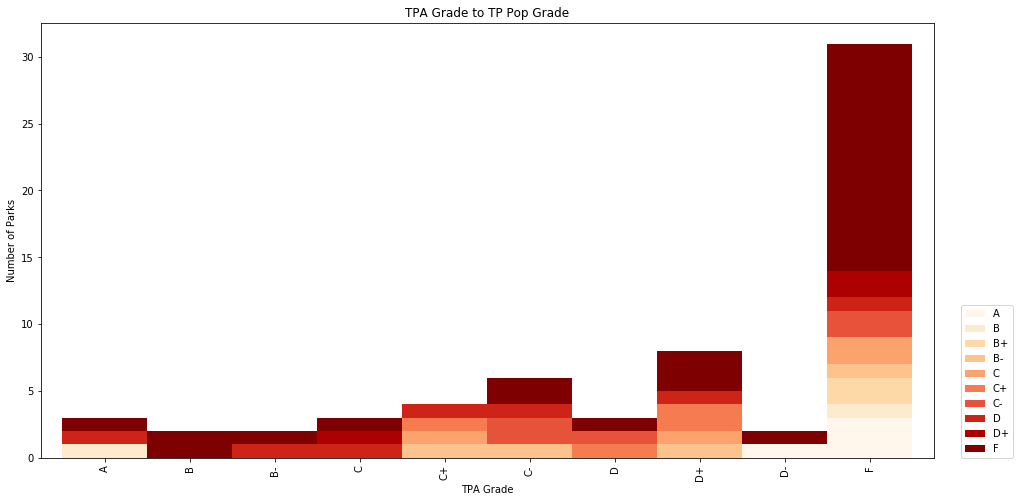

In [116]:
t.plot.bar(width=1,stacked=True,cmap='OrRd',figsize=(16,8))
plt.xlabel('TPA Grade')
plt.ylabel('Number of Parks')
plt.legend(loc=(1.03,0))
plt.title('TPA Grade to TP Pop Grade')
plt.savefig(join(path_exp,'190703_TPA Grade to TP Pop Grade.pdf'))

In [117]:
t

tppop_grade,A,B,B+,B-,C,C+,C-,D,D+,F
tpa_grade,,,,,,,,,,
A,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
B-,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
C+,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0
C-,0.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0,0.0,2.0
D,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
D+,0.0,0.0,0.0,1.0,1.0,2.0,0.0,1.0,0.0,3.0
D-,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [916]:
t1= comp[['tp_grade_x','tppop_grade']].groupby(['tp_grade_x','tppop_grade']).agg({'tppop_grade':'count'})['tppop_grade'].unstack().fillna(0)

2

In [125]:
comp

,GISPROPNUM,TYPECATEGO_x,tp_palmm_x,tp_palmm_y,tp_grade_x,tppop_grade,tppopdens_grade,tp_grade_y,tpa_grade
0,Q104,Community Park,70.0,70.0,C-,C-,F,C-,D
1,B129,Community Park,78.0,78.0,C+,B-,D,C+,C-
2,B126,Community Park,68.0,68.0,D+,C,D,D+,F
3,Q371,Community Park,26.0,26.0,F,F,F,F,F
4,M353,Community Park,75.0,75.0,C,C-,F,C,F
5,Q004,Community Park,84.0,84.0,B,B-,C,B,D+
6,B021,Community Park,73.0,73.0,C,D+,F,C,C
7,M089,Community Park,96.0,96.0,A,B,C+,A,A
8,M058,Community Park,83.0,83.0,B,D,D,B,C+
9,Q492,Community Park,60.0,60.0,F,F,F,F,D+
